In [1]:
import numpy as np
import torch
import torchvtk.rendering as R
import torchvtk.utils as Ru
# from torchinterp1d import interp1d
import torchpwl


from monai.transforms import LoadImage, EnsureType, EnsureChannelFirst, ScaleIntensity, Compose, Spacing, NormalizeIntensity
from monai.networks.blocks import ResidualUnit, Convolution
from monai.optimizers import Novograd

import matplotlib.pyplot as plt

C:\Users\pcarnah\miniforge3\envs\monai14\Lib\site-packages\ignite\handlers\checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
C:\Users\pcarnah\miniforge3\envs\monai14\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_tf = Compose([
    LoadImage(),
    EnsureChannelFirst(),
    Spacing([2.5,2.5,2.5]),
    # ScaleIntensity(),
    EnsureType()
])

In [3]:
vol = load_tf('CTChest.nii.gz').unsqueeze(0)

In [4]:
print(vol.min(), vol.mean(), vol.max())
print(vol.size())

metatensor(-3024.) metatensor(-1093.6547) metatensor(3071.)
torch.Size([1, 1, 157, 157, 139])


In [5]:
n = 10
a = torch.linspace(vol.min(),vol.max(),n)
b = torch.ones(n) * 0.333
c = torch.rand(n)

tf = [torch.stack([a,b,b,b,b*0.1], dim=1).cuda()]
tf

tf = [torch.tensor([
    [-3500, 1,1,1, 0.0],
    [-200, 1,1,1, 0.0],
    [200, 1,1,1, 0.05],
    [1535, 1,1,1, 0.5],
    [3071,1,1,1, 0.65],
]).cuda()]

In [6]:
# tf = [torch.rand((5,5))]
m = R.raycast.get_view_mat(torch.tensor([0.,-200.,-300.]), look_to=torch.tensor([0.,0,0.]), look_up=torch.tensor([0.,0.,1.]))
rend = R.VolumeRaycaster(ray_samples=512)

v = vol.new_ones(4, np.prod(vol.shape[2:])).cuda()
v[3,:] = torchpwl.calibrate1d(vol.ravel().unsqueeze(0).T.cuda(), tf[0][:,0].unsqueeze(0), tf[0][:,4:].T).T
v = v.reshape(1,4,*vol.size()[2:])
# v = interp1d(tf[0][:,0].unsqueeze(0), tf[0][:,1:].T, vol.ravel().expand(4,-1).cuda()).reshape(1,4,*vol.size()[2:])

c:\d\dev\torchvtk\torchvtk\rendering\raycast.py:90: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Cross.cpp:66.)
  x = F.normalize(torch.cross(look_up, z), dim=1)
C:\Users\pcarnah\miniforge3\envs\monai14\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
out = rend(v, view_mat=m.cuda())
out.size()

C:\Users\pcarnah\miniforge3\envs\monai14\Lib\site-packages\torch\nn\functional.py:4902: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


torch.Size([1, 3, 224, 224])

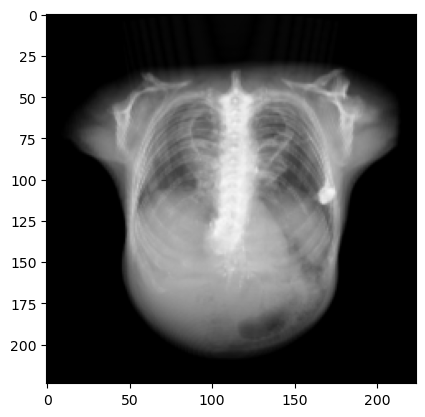

In [8]:
plt.imshow(out.squeeze().permute([1,2,0]).cpu().numpy())

In [9]:
rend.get_camera_matrix(torch.tensor([[0,1.,0.]]))
high_dim = rend(torch.rand(1,10,224,224,224).cuda(), view_mat=m.cuda())
high_dim.size()

torch.Size([1, 9, 224, 224])

In [10]:
class CNNRender(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.render = R.VolumeRaycaster()
        # self.res = ResidualUnit(3, 1, 4)
        # self.out = Convolution(3, 4, 4, kernel_size=1, act='sigmoid')
        self.n = 5
        # a = torch.linspace(0,1,self.n)
        # b = torch.ones(n)
        # c = torch.rand(n)

        # tf = torch.stack([a,b,b,b,b*0.1], dim=1)
        # self.tf = torch.nn.Parameter(tf.contiguous())
        # self.alphas = torch.nn.Parameter(torch.ones(self.n) * 0.1)
        # self.pwl = torchpwl.Calibrator(tf[0][:,0:1].T, monotonicity=1)
        self.pwl = torchpwl.PWL(num_channels=4, num_breakpoints=40)

    def forward(self, x, view_mat):
        # out = self.res(x)
        # out = self.out(out)

        # v = x.new_ones(4, np.prod(x.shape[2:]))
        # v[3,:] = torch.sigmoid(self.pwl(x.ravel().unsqueeze(0).T).T)
        v = torch.sigmoid(self.pwl(x.ravel().expand(4,-1).T).T)
        v = v.reshape(x.size(0), 4, *x.size()[2:])
        
        # v = v = interp1d(tf[:,0].unsqueeze(0), tf[:,1:].T, vol.ravel().expand(4,-1).cuda()).reshape(1,4,*vol.size()[2:])
        ren = self.render(v, view_mat=view_mat)

        return ren

In [11]:
net = CNNRender().cuda()
list(net.parameters())


[Parameter containing:
 tensor([[ 1.4073,  1.5021,  0.8201, -3.7990,  2.0209,  1.9094, -1.7514,  0.1801,
          -1.2999, -0.3321,  0.6736, -1.8177,  6.0104,  0.8405, -0.0224, -2.0166,
          -2.3241,  1.7289,  2.6593,  2.0073,  0.0478, -2.7414,  2.3610,  1.0231,
          -3.0615,  2.0135,  0.9166, -1.1768,  0.3351,  2.0565, -2.3990,  1.0198,
          -0.0743,  3.9661,  2.7037,  1.6288,  1.5733, -4.6108,  0.7535,  1.7764],
         [-0.6721,  2.1072,  1.6930, -3.2167, -0.5252,  0.1595,  1.0011,  1.3738,
           1.5677,  0.7402, -0.4981, -1.2675,  0.1572,  2.3303,  2.6295,  1.1277,
          -0.2917,  1.0226, -1.8680, -1.2687,  4.1668,  2.4118,  0.2003, -2.6024,
          -1.3005, -0.0334,  1.0384,  0.1321,  2.1852,  0.9266, -3.5638, -1.1158,
          -0.8663,  0.8465,  2.1139, -1.8021,  1.4056,  2.5269, -1.9629,  1.2233],
         [-0.8372, -3.6935,  2.4452, -2.4271,  1.6671, -1.6898,  4.9939, -1.9228,
          -2.5030,  0.3698,  3.2969, -0.3339,  0.9621, -0.8953,  3.1726, 

In [ ]:
transform = Compose([ScaleIntensity(), NormalizeIntensity()])
vs = transform(vol).cuda()

In [ ]:
m = R.raycast.get_view_mat(torch.tensor([0.,-200.,-300.]), look_to=torch.tensor([0.,0,0.]), look_up=torch.tensor([0.,0.,1.])).cuda()

opt = torch.optim.AdamW(net.parameters(), lr=1e-2)
# opt = Novograd(net.parameters())
for _ in range(100):
    opt.zero_grad()
    y = net(vs, m)
    loss = torch.nn.functional.mse_loss(y, out.cuda().detach())
    print(loss)
    loss.backward()
    opt.step()

In [ ]:
y = net(vs.cuda(), m.cuda())
plt.imshow(y.squeeze().permute([1,2,0]).cpu().detach().numpy())

In [ ]:
n = 10
a = torch.linspace(vol.min(),vol.max(),n)
b = torch.ones(n)
c = torch.rand(n)

tf = [torch.stack([a,b,b,b,c], dim=1).cuda()]
tf[0].requires_grad = True

v = interp1d(tf[0][:,0].unsqueeze(0), tf[0][:,1:].T, vol.ravel().expand(4,-1).cuda()).reshape(1,4,*vol.size()[2:])

In [ ]:
y = vol.new_ones(4, np.prod(vol.shape[2:]))
y[3,:] = torchpwl.calibrate1d(vol.ravel().unsqueeze(0).T.cuda(), tf[0][:,0].unsqueeze(0), tf[0][:,4:].T).T


In [ ]:
y = y.reshape(1,4,*vol.size()[2:])

In [ ]:
pwl = torchpwl.PWL(num_channels=1, num_breakpoints=5)
pwl(vs.cpu().ravel().unsqueeze(0).T).max()